In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
head = "/home/dhoogla/PhD/clean-ids-collection"
iscx_data = {    
    'iscxids2012': f'{head}/iscx-ids2012/dirty-with-metadata/iscx-ids2012.parquet',
    'iscxids2012-1': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedMonJun14Flows.parquet',
    'iscxids2012-2': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedSatJun12Flows.parquet',
    'iscxids2012-3': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedSunJun13Flows.parquet',
    'iscxids2012-4': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedThuJun17-1Flows.parquet',
    'iscxids2012-5': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedThuJun17-2Flows.parquet',
    'iscxids2012-6': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedThuJun17-3Flows.parquet',
    'iscxids2012-7': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedTueJun15-1Flows.parquet',
    'iscxids2012-8': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedTueJun15-2Flows.parquet',
    'iscxids2012-9': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedTueJun15-3Flows.parquet',
    'iscxids2012-10': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedWedJun16-1Flows.parquet',
    'iscxids2012-11': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedWedJun16-2Flows.parquet',
    'iscxids2012-12': f'{head}/iscx-ids2012/dirty-with-metadata/TestbedWedJun16-3Flows.parquet',
}


In [3]:
dataset = "iscxids2012-1"
datapaths = [f"{iscx_data[dataset]}"]


In [4]:
df = pd.concat(objs=[pd.read_parquet(path) for path in datapaths], ignore_index=True, copy=False, sort=False, verify_integrity=False)

In [5]:
df.columns

Index(['app_name_AOL-ICQ', 'app_name_Anet', 'app_name_Authentication',
       'app_name_BGP', 'app_name_BitTorrent', 'app_name_Citrix',
       'app_name_Common-P2P-Port', 'app_name_Common-Ports', 'app_name_DNS',
       'app_name_DNS-Port',
       ...
       'source', 'proto_icmp_ip', 'proto_igmp', 'proto_ip', 'proto_tcp_ip',
       'proto_udp_ip', 'source_port', 'destination', 'destination_port',
       'tag'],
      dtype='object', length=123)

In [6]:
df = df[['destination_port', 'tag']]
df['tag'] = df['tag'].astype(dtype='object')
df['tag'].value_counts()

Normal    160137
Attack      3630
Name: tag, dtype: int64

In [7]:
tag_idx = df.columns.size -1
attacks = df.loc[df['tag'] != "Normal"].index
df.iloc[attacks, tag_idx] = 1.0
df.iloc[df.index.difference(attacks), tag_idx] = 0.0
df['tag'] = df['tag'].astype(dtype='float32', copy=False)
print(df['tag'].value_counts())

0.0    160137
1.0      3630
Name: tag, dtype: int64


In [8]:
col = df.columns[-1]
cols = df.columns[:-1]
vc = df[col].value_counts()
n = vc.iloc[-1]
m = vc.iloc[0]
initial_cut = df.loc[df[col] == vc.index[0]].sample(n=int(m-n), replace=False)
df = df.drop(index=initial_cut.index)

In [9]:
print(df.shape)
df['tag'].value_counts()

(7260, 2)


1.0    3630
0.0    3630
Name: tag, dtype: int64

In [10]:
gp = df.groupby('tag')
with pd.option_context('display.max_rows', 50):
    print(gp.get_group(0.0)['destination_port'].value_counts())
    print(gp.get_group(1.0)['destination_port'].value_counts())

80       2311
53        789
443       199
110        49
25         34
         ... 
62027       1
52574       1
59039       1
54971       1
60031       1
Name: destination_port, Length: 177, dtype: int64
80       2057
443        91
0          55
143        28
4444       27
         ... 
15002       1
1112        1
4998        1
1065        1
9944        1
Name: destination_port, Length: 667, dtype: int64


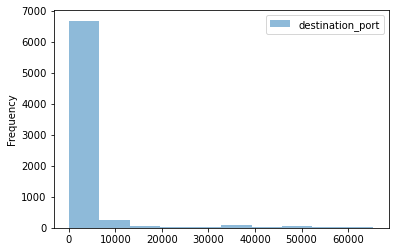

In [11]:
hist = df['destination_port'].plot.hist(by=df['tag'], bins=10, stacked=True, alpha=0.5, legend=True)

In [12]:
model = RF()
best_param_dict = {
        'bootstrap': True,
        'max_depth': 16,
        'max_features': 'sqrt',
        'min_impurity_decrease': 0.0,
        'min_samples_leaf': 2,
        'n_estimators': 10,
        'max_samples': 0.5,
        'criterion': 'entropy',
        'n_jobs': -1,
        }
model.set_params(**best_param_dict)

RandomForestClassifier(criterion='entropy', max_depth=16, max_features='sqrt',
                       max_samples=0.5, min_samples_leaf=2, n_estimators=10,
                       n_jobs=-1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['destination_port'], df['tag'], test_size=0.8, random_state=42)

In [14]:
model.fit(X=X_train.array.reshape(-1,1), y=y_train.array)

RandomForestClassifier(criterion='entropy', max_depth=16, max_features='sqrt',
                       max_samples=0.5, min_samples_leaf=2, n_estimators=10,
                       n_jobs=-1)

In [15]:
intra_outputs = model.predict(X=X_test.array.reshape(-1,1))
intra_acc = accuracy_score(y_true=y_test, y_pred=intra_outputs)
intra_rec = recall_score(y_true=y_test, y_pred=intra_outputs)
intra_pre = precision_score(y_true=y_test, y_pred=intra_outputs)
print(f"{dataset} => Destination Port")
print(f"Accuracy: {intra_acc:.3f}")
print(f"Recall: {intra_rec:.3f}")
print(f"Precision: {intra_pre:.3f}")


iscxids2012-1 => Destination Port
Accuracy: 0.675
Recall: 0.385
Precision: 0.904
